<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21222740/Final_Training_for_GRU_with_GLOVE_41_testing_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a30a2ad799910d48f45f67793fb1d09f31560ae3773fa14870108018fa213261ae62aeb020867952a30d8094a21359c2546a6475193ac986bc2645a191d848c7223dbd5c68600aeb8f17d5a979be9750827328816b6743cf0d74ca79e5a28878f8606f4d3cd2176678d18b8a70a20bbf9be8037aa238d4b56bd1a0ba1a8d1fb4003bbd12f51fa6d438aaa8a7e8fa90a9291e62969f7df78c34dc6a71c76fb2f1c11e2964127136ec4d5554e9f1bdd7c530f8ddf987a08dd6cb91a849e4e98a2089149d22cb00ca687688c756071af4270e392fd79699c1f4a35ca16597523ca8bfe37fea11d5911465ea51d6eb17c1e3663da806763c8ef4e96e1f0a9ae9ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


In [ ]:
# Load dataset
data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')


In [ ]:
data = data.sample(frac =0.01, random_state=42)  # Sample 5% of the data for faster processing
print(data.shape)

(30000, 3)


In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(file):
    words = {}
    with open(file, 'r') as f:
        for line in f:
            line = line.split(' ')
            words[line[0]] = np.array(line[1:], dtype=float)
    return words


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-10-05 18:40:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-05 18:40:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-05 18:40:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

# Display the first 5 word embeddings
list(glove_embeddings.items())[:5]

[('the',
  array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
         -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
          0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
         -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
          0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
         -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
          0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
          0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
         -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
         -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
         -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
         -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
         -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
         -1.2526

In [ ]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()


In [ ]:
# Tokenization and Lemmatization function
def message_to_token_list(s, words, tokenizer):
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t in words]
    return useful_tokens

In [ ]:
# Tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review_text'])
sequences = tokenizer.texts_to_sequences(data['review_text'])

In [ ]:
# Padding sequences
padded_sequences = pad_sequences(sequences, padding='post')

In [ ]:
# Get labels
labels = data['class_index'] - 1  # Adjust class index to be 0-based for classification

In [ ]:
embedding_dim = 100  # GloVe embedding dimension
word_index = tokenizer.word_index
print(len(word_index))
# Create an embedding matrix
def create_embedding_matrix(word_index, glove_embeddings, embedding_dim=100):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in glove_embeddings:
            embedding_matrix[i] = glove_embeddings[word]
    return embedding_matrix

65243


In [ ]:
# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(18000, 209)
(6000, 209)
(6000, 209)


In [ ]:
from tensorflow.keras.layers import Bidirectional,Conv1D

In [ ]:

# Define the model with GloVe embeddings and a modified GRU architecture
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
sequence_length = X_train.shape[1]  # Length of each input sequence
embedding_matrix = create_embedding_matrix(word_index, glove_embeddings, embedding_dim=100)

# Build the model
model = Sequential()

# Embedding layer initialized with GloVe embeddings, non-trainable (set trainable=False)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=X_train.shape[1],
                    weights=[embedding_matrix],
                    trainable=True))
# Add a 1D Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))



# GRU layer with return_sequences=True for compatibility with pooling
model.add(Bidirectional(GRU(128, return_sequences=True)))

# Dropout after GRU layer
model.add(Dropout(0.5))  # after GRU

# Global Max Pooling layer for dimensionality reduction
model.add(GlobalMaxPool1D())

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output layer for classification into 5 classes (rating from 1 to 5)
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       6,524,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,524,400 (24.89 MB)

 Trainable params: 6,524,400 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, verbose=1)



Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.2348 - loss: 1.6586 - val_accuracy: 0.3755 - val_loss: 1.4601
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3852 - loss: 1.3863 - val_accuracy: 0.4007 - val_loss: 1.3518
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4676 - loss: 1.2255 - val_accuracy: 0.4638 - val_loss: 1.2697
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5226 - loss: 1.0991 - val_accuracy: 0.4642 - val_loss: 1.2313
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5683 - loss: 0.9988 - val_accuracy: 0.4675 - val_loss: 1.2217
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6512 - loss: 0.8393 - val_accuracy: 0.4480 - val_loss: 1.2740
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7317 - loss: 0.6759 - val_accuracy: 0.4383 - val_loss: 1.3216
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8011 - loss: 0.5187 - val_ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}") #100d , bidirectional GRU and 10 epochs


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4216 - loss: 1.8473
Test Accuracy: 0.4124999940395355


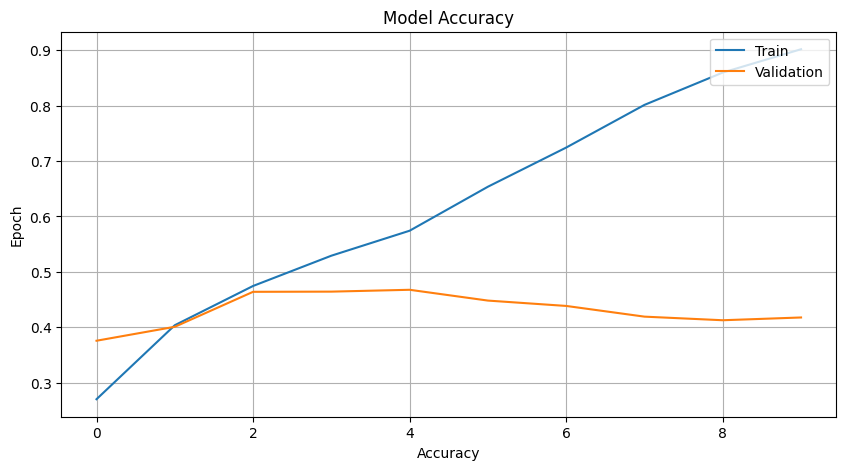

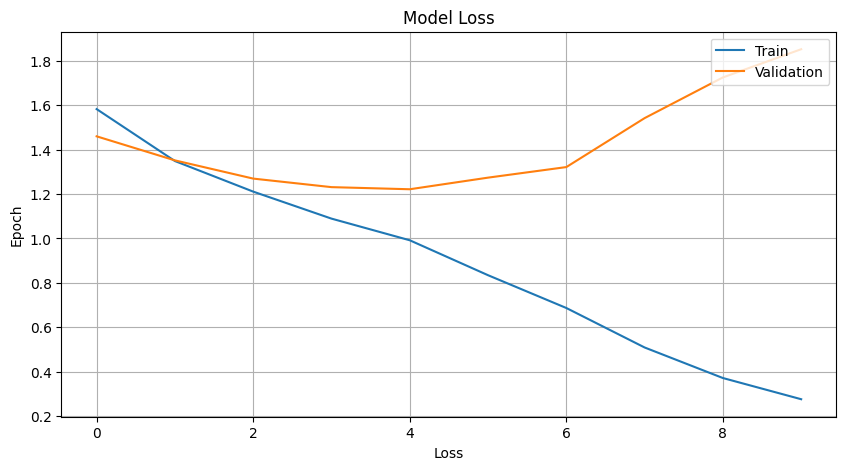

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)  # Convert to class labels

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1-score, precision, and recall
f1 = f1_score(y_val, y_pred_classes, average='weighted')
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')

print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Classification report for detailed metrics
print(classification_report(y_val, y_pred_classes))


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Accuracy: 0.4175
F1-Score: 0.4195
Precision: 0.4261
Recall: 0.4175
              precision    recall  f1-score   support

           0       0.57      0.44      0.50      1208
           1       0.34      0.39      0.36      1148
           2       0.35      0.33      0.34      1198
           3       0.37      0.41      0.39      1247
           4       0.49      0.52      0.51      1199

    accuracy                           0.42      6000
   macro avg       0.43      0.42      0.42      6000
weighted avg       0.43      0.42      0.42      6000

